## 루브릭

1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.	
- 3가지 이상의 모델이 성공적으로 시도됨
2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.	
- gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함
3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.	
- 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

In [5]:
import pandas
import konlpy
import gensim
import numpy as np
import tensorflow as tf
import os
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt


print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [6]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')
print(train_data.shape) #(150000, 3)
train_data.head()

(150000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터로더 구성

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [7]:
train_data.info() # 결측치 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [8]:
# 토크나이저로 토큰화
# 불용어 제거 등

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복행 제거
    train_data = train_data.dropna(how = 'any') # 한값이라도 NA이면 해당 행 제거
    test_data.drop_duplicates(subset=['document'], inplace=True) # 중복행 제거
    test_data = test_data.dropna(how = 'any') # 한값이라도 NA이면 해당 행 제거
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()   #tolist() 함수는 같은 위치의 데이터를 묶어준다
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index \
                else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), \
            X_test, np.array(list(test_data['label'])),word_to_index
    
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)
index_to_word = {index:word for word, index in word_to_index.items()}

In [9]:
print(len(x_train))

146182


In [10]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [11]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델 구성을 위핸 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [12]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 \
{np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 \
maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [13]:
# 패딩방식은 pre(앞쪽에 패딩) 로 설정 순차학습이므로 post가 더 유리하다
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


## 모델 구성 및 validation set 구성
- 모델 3종류
1. RNN
1. 1-D CNN
1. GlovalMaxPooling1D

In [14]:
# val 비율 0.2 로 분리 약 30000

# validation set 30000건 분리
x_val = x_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 
partial_x_train = x_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(116182, 41)
(116182,)


In [32]:
#model1

vocab_size = 10000  # 어휘 사전의 크기입니다(20000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model1.add(tf.keras.layers.Dense(8, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [33]:
#model2

"""#1-D CNN은 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캐닝 하면서 
7단어 이내에서 발견되는 특징을 추출하여 그것으로 문장을 분류하는 방식으로 사용
"""
vocab_size = 10000  # 어휘 사전의 크기입니다(20000개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.MaxPooling1D(5))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [34]:
#model3

# 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출 하는 방식()
# GlobalMaxPooling1D() 레이어 이용

vocab_size = 10000  # 어휘 사전의 크기입니다(20000개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.GlobalMaxPooling1D())
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


## 모델 훈련 개시

In [35]:
epochs=7  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.


model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history1 = model1.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/7
286/286 [==============================] - 3s 7ms/step - loss: 0.5636 - accuracy: 0.7384 - val_loss: 0.4589 - val_accuracy: 0.8450
Epoch 2/7
286/286 [==============================] - 2s 6ms/step - loss: 0.4450 - accuracy: 0.8517 - val_loss: 0.4045 - val_accuracy: 0.8717
Epoch 3/7
286/286 [==============================] - 2s 6ms/step - loss: 0.4042 - accuracy: 0.8609 - val_loss: 0.3720 - val_accuracy: 0.8758
Epoch 4/7
286/286 [==============================] - 2s 6ms/step - loss: 0.3769 - accuracy: 0.8662 - val_loss: 0.3474 - val_accuracy: 0.8826
Epoch 5/7
286/286 [==============================] - 2s 6ms/step - loss: 0.3555 - accuracy: 0.8719 - val_loss: 0.3269 - val_accuracy: 0.8882
Epoch 6/7
286/286 [==============================] - 2s 6ms/step - loss: 0.3365 - accuracy: 0.8775 - val_loss: 0.3089 - val_accuracy: 0.8953
Epoch 7/7
286/286 [==============================] - 2s 6ms/step - loss: 0.3193 - accuracy: 0.8831 - val_loss: 0.2943 - val_accuracy: 0.8980


In [36]:
print(epochs)

7


In [37]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history2 = model2.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/7
286/286 [==============================] - 2s 5ms/step - loss: 0.4747 - accuracy: 0.7727 - val_loss: 0.3205 - val_accuracy: 0.8656
Epoch 2/7
286/286 [==============================] - 1s 5ms/step - loss: 0.3219 - accuracy: 0.8625 - val_loss: 0.2777 - val_accuracy: 0.8863
Epoch 3/7
286/286 [==============================] - 1s 5ms/step - loss: 0.2899 - accuracy: 0.8795 - val_loss: 0.2487 - val_accuracy: 0.9032
Epoch 4/7
286/286 [==============================] - 1s 5ms/step - loss: 0.2615 - accuracy: 0.8931 - val_loss: 0.2232 - val_accuracy: 0.9143
Epoch 5/7
286/286 [==============================] - 1s 5ms/step - loss: 0.2325 - accuracy: 0.9082 - val_loss: 0.1853 - val_accuracy: 0.9340
Epoch 6/7
286/286 [==============================] - 1s 5ms/step - loss: 0.2012 - accuracy: 0.9236 - val_loss: 0.1554 - val_accuracy: 0.9471
Epoch 7/7
286/286 [==============================] - 1s 5ms/step - loss: 0.1715 - accuracy: 0.9379 - val_loss: 0.1308 - val_accuracy: 0.9580


In [38]:
print(epochs)

7


In [39]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              

history3 = model3.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/7
286/286 [==============================] - 1s 4ms/step - loss: 0.5775 - accuracy: 0.7425 - val_loss: 0.4075 - val_accuracy: 0.8318
Epoch 2/7
286/286 [==============================] - 1s 3ms/step - loss: 0.3721 - accuracy: 0.8402 - val_loss: 0.3217 - val_accuracy: 0.8633
Epoch 3/7
286/286 [==============================] - 1s 4ms/step - loss: 0.3241 - accuracy: 0.8619 - val_loss: 0.2894 - val_accuracy: 0.8809
Epoch 4/7
286/286 [==============================] - 1s 4ms/step - loss: 0.2978 - accuracy: 0.8760 - val_loss: 0.2664 - val_accuracy: 0.8931
Epoch 5/7
286/286 [==============================] - 1s 3ms/step - loss: 0.2784 - accuracy: 0.8861 - val_loss: 0.2487 - val_accuracy: 0.9016
Epoch 6/7
286/286 [==============================] - 1s 4ms/step - loss: 0.2629 - accuracy: 0.8931 - val_loss: 0.2341 - val_accuracy: 0.9088
Epoch 7/7
286/286 [==============================] - 1s 3ms/step - loss: 0.2492 - accuracy: 0.8995 - val_loss: 0.2218 - val_accuracy: 0.9146


## Loss, Accuracy 시각화

Text(0.5, 1.0, 'model3_acc')

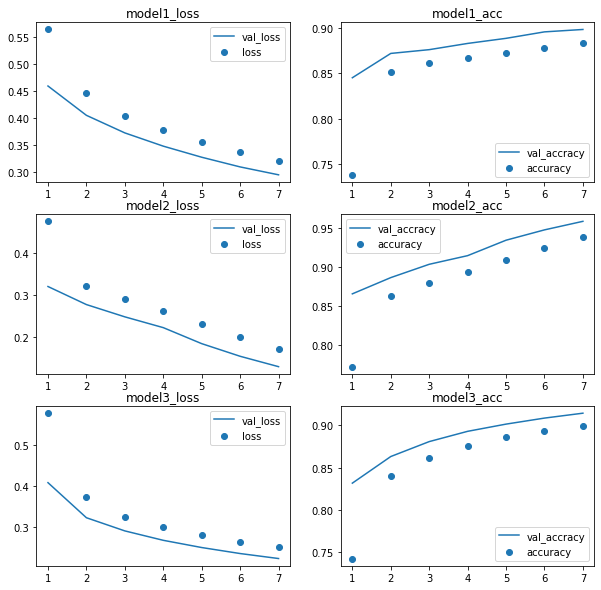

In [40]:
epoch = np.arange(1,epochs+1)
plt.figure(figsize=(10,10))
plt.subplot(321)
plt.scatter(epoch,history1.history['loss'], label='loss')
plt.plot(epoch,history1.history['val_loss'], label='val_loss')
plt.legend()
plt.title("model1_loss")
plt.subplot(322)
plt.scatter(epoch,history1.history['accuracy'], label='accuracy')
plt.plot(epoch,history1.history['val_accuracy'], label='val_accracy')
plt.legend()
plt.title("model1_acc")

plt.subplot(323)
plt.scatter(epoch,history2.history['loss'], label='loss')
plt.plot(epoch,history2.history['val_loss'], label='val_loss')
plt.legend()
plt.title("model2_loss")
plt.subplot(324)
plt.scatter(epoch,history2.history['accuracy'], label='accuracy')
plt.plot(epoch,history2.history['val_accuracy'], label='val_accracy')
plt.legend()
plt.title("model2_acc")

plt.subplot(325)
plt.scatter(epoch,history3.history['loss'], label='loss')
plt.plot(epoch,history3.history['val_loss'], label='val_loss')
plt.legend()
plt.title("model3_loss")
plt.subplot(326)
plt.scatter(epoch,history3.history['accuracy'], label='accuracy')
plt.plot(epoch,history3.history['val_accuracy'], label='val_accracy')
plt.legend()
plt.title("model3_acc")

In [41]:
results1 = model1.evaluate(x_test,  y_test, verbose=2)
results2 = model2.evaluate(x_test,  y_test, verbose=2)
results3 = model3.evaluate(x_test,  y_test, verbose=2)

print("evaluate model1 :",results1) # loss, accuracy
print("evaluate model2 :",results2)
print("evaluate model3 :",results3)

1537/1537 - 3s - loss: 0.3876 - accuracy: 0.8434
1537/1537 - 2s - loss: 0.4220 - accuracy: 0.8423
1537/1537 - 2s - loss: 0.3721 - accuracy: 0.8446
evaluate model1 : [0.38763219118118286, 0.8433590531349182]
evaluate model2 : [0.42200055718421936, 0.8423011898994446]
evaluate model3 : [0.3721451759338379, 0.8445999622344971]


## 학습된 Embedding 레이어 분석

In [42]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

In [43]:
embedding_layer1 = model1.layers[0]
weights = embedding_layer1.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [44]:
vectors = model1.get_weights()[0]

In [45]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [46]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, 
                                                         binary=False)

In [47]:
vector = word_vectors['추천']
vector

array([-0.05243468,  0.02308796,  0.07008382,  0.1096475 ,  0.03476061,
       -0.11451449,  0.03063659, -0.04622612,  0.05450479,  0.00764661,
       -0.03882304,  0.06935218, -0.04202202,  0.08477476,  0.02859046,
       -0.03358136], dtype=float32)

In [48]:
word_vectors.similar_by_word("추천")

[('。', 0.9434241652488708),
 ('OST', 0.9256173968315125),
 ('푹', 0.9235772490501404),
 ('식사', 0.9209716320037842),
 ('달달', 0.9190594553947449),
 ('대박', 0.9180808067321777),
 ('정리', 0.9160281419754028),
 ('연인', 0.9159424304962158),
 ('시스', 0.9154045581817627),
 ('개웃', 0.9153022170066833)]

In [49]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path2 = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec2.txt'
f = open(word2vec_file_path2, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors2 = model2.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors2[i, :])))))
f.close()

In [50]:
word_vectors2 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path2, 
                                                         binary=False)

In [51]:
print(word_vectors2['추천'])

[-0.03920706 -0.02555488  0.01872399 -0.03775585  0.07922074  0.04704689
  0.05903839  0.05211259  0.01722712 -0.05446728 -0.12121018  0.08648243
  0.00793268  0.02811423  0.10686548 -0.08869047]


In [52]:
word_vectors2.similar_by_word("추천")

[('빠져', 0.8721400499343872),
 ('모델', 0.850459098815918),
 ('성공', 0.837326169013977),
 ('빨간', 0.8346065282821655),
 ('상큼', 0.8253774046897888),
 ('기다려', 0.8083670139312744),
 ('끊이', 0.8049447536468506),
 ('남녀노소', 0.8038849234580994),
 ('이뻐', 0.7988002896308899),
 ('감춰진', 0.7950519323348999)]

In [53]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path3 = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec3.txt'
f = open(word2vec_file_path3, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors3 = model3.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors3[i, :])))))
f.close()

In [54]:
word_vectors3 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path3, 
                                                         binary=False)

In [55]:
print(word_vectors3['추천'])

[-0.08753727 -0.14830239 -0.10275319 -0.13429077 -0.14217031  0.03381395
 -0.12785797  0.20592506 -0.12001259 -0.13856274  0.04852999 -0.03265006
 -0.12481397 -0.10676087 -0.16738944 -0.00829345]


In [56]:
print(word_vectors3.similar_by_word("추천"))

[('★', 0.9087114930152893), ('어여', 0.9071704149246216), ('처', 0.9028778076171875), ('생물', 0.8997148871421814), ('발랄', 0.8937371373176575), ('죽인다', 0.8796045184135437), ('윤계상', 0.8774604797363281), ('닥치', 0.8771536350250244), ('이쁘', 0.8730746507644653), ('애니메이션', 0.871359646320343)]


In [57]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_file_path1 = os.getenv('HOME')+'/aiffel/word_embadding/word2vec_ko.model'
word2vec_pre = Word2VecKeyedVectors.load(word2vec_file_path1)

In [58]:
word2vec_pre.wv.similar_by_word('추천')

[('천거', 0.7103838920593262),
 ('초빙', 0.687961220741272),
 ('초청', 0.6826260089874268),
 ('위촉', 0.6571412682533264),
 ('포상', 0.6499664783477783),
 ('선출', 0.6489635705947876),
 ('소개', 0.6427397727966309),
 ('임명', 0.6394351124763489),
 ('등용', 0.6328903436660767),
 ('추대', 0.6315879225730896)]

## 자체 학습과 사전학습된 레이어 비교

### 모델간 비교

- 자체 학습별로 다른 유사한 단어가 추출 되었다.
- 같은 데이터라도 다른 학습방식이 적용되면 유사한 단어 추출시 다른 결과가 출력된다
- 학습방식에 따라 가중치를 갱신하는 방식이 달라 각 단어벡터의 값이 다르기 떄문이다

### 자체-사전 학습간 비교

- 같은 단어와 유사한 단어를 추출하였을때 다른 결과가 출력되었다
- 기반이 되는 학습 데이터가 다르기 때문에 나타날 수 밖에 없는 결과로 보인다.
- 사전 학습 결과는 다소 사전적인 의미기준으로 유사 단어를 출력해준다

## 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [59]:
from gensim.models import KeyedVectors
# 사전 학습된 한국어 Word2Vec 임베딩 다시 읽기 

word2vec_file_path1 = os.getenv('HOME')+'/aiffel/word_embadding/word2vec_ko.model'
word2vec_pre = Word2VecKeyedVectors.load(word2vec_file_path1)

In [60]:
len(word2vec_pre.wv)

302960

- 단어사전 크기 25000으로 증가

In [61]:
def load_data(train_data, test_data, num_words=25000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복행 제거
    train_data = train_data.dropna(how = 'any') # 한값이라도 NA이면 해당 행 제거
    test_data.drop_duplicates(subset=['document'], inplace=True) # 중복행 제거
    test_data = test_data.dropna(how = 'any') # 한값이라도 NA이면 해당 행 제거
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()   #tolist() 함수는 같은 위치의 데이터를 묶어준다
    counter = Counter(words)
    counter = counter.most_common(25000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index \
                else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), \
            X_test, np.array(list(test_data['label'])),word_to_index
    
x_train1, y_train1, x_test1, y_test1, word_to_index1 = load_data(train_data, test_data)
index_to_word1 = {index:word for word, index in word_to_index1.items()}

In [62]:
x_train1 = tf.keras.preprocessing.sequence.pad_sequences(x_train1,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

x_test1 = tf.keras.preprocessing.sequence.pad_sequences(x_test1,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

In [63]:
len(index_to_word1)

25000

In [64]:
vocab_size = 25000    # 어휘 사전의 크기입니다
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word1[i] in word2vec_pre.wv:   #한국어 word2Vec 임베딩
        embedding_matrix[i] = word2vec_pre.wv[index_to_word1[i]]

In [65]:
from tensorflow.keras.initializers import Constant

vocab_size = 25000    # 어휘 사전의 크기입니다
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 100)           2500000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [66]:
# val 비율 변경 
# validation set 
x_val1 = x_train1[:40000]   
y_val1 = y_train1[:40000]

# validation set을 제외한 나머지 
partial_x_train1 = x_train1[40000:]  
partial_y_train1 = y_train1[40000:]

In [70]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train1,
                    partial_y_train1,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val1, y_val1),
                    verbose=1)

Epoch 1/5
208/208 [==============================] - 2s 7ms/step - loss: 0.2554 - accuracy: 0.8975 - val_loss: 0.3806 - val_accuracy: 0.8419
Epoch 2/5
208/208 [==============================] - 1s 6ms/step - loss: 0.2377 - accuracy: 0.9065 - val_loss: 0.3803 - val_accuracy: 0.8419
Epoch 3/5
208/208 [==============================] - 1s 6ms/step - loss: 0.2239 - accuracy: 0.9125 - val_loss: 0.3957 - val_accuracy: 0.8412
Epoch 4/5
208/208 [==============================] - 1s 6ms/step - loss: 0.2090 - accuracy: 0.9199 - val_loss: 0.4053 - val_accuracy: 0.8417
Epoch 5/5
208/208 [==============================] - 1s 6ms/step - loss: 0.1961 - accuracy: 0.9254 - val_loss: 0.4094 - val_accuracy: 0.8405


Text(0.5, 1.0, 'model_acc')

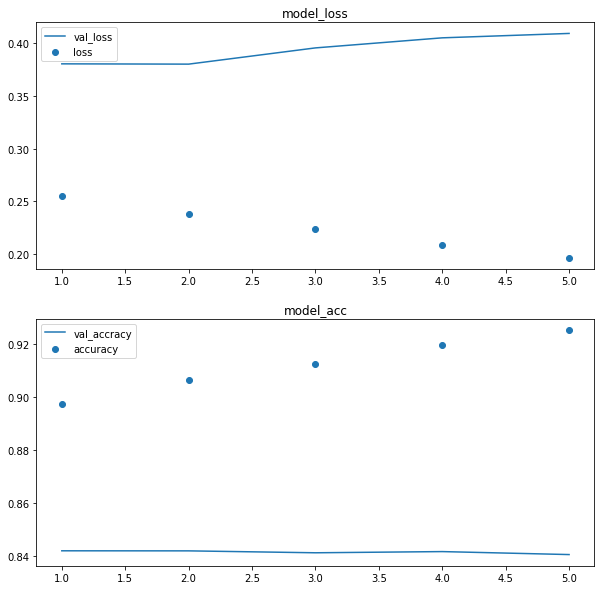

In [71]:
epoch = np.arange(1,epochs+1)
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.scatter(epoch,history.history['loss'], label='loss')
plt.plot(epoch,history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("model_loss")
plt.subplot(212)
plt.scatter(epoch,history.history['accuracy'], label='accuracy')
plt.plot(epoch,history.history['val_accuracy'], label='val_accracy')
plt.legend()
plt.title("model_acc")


In [72]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test1,  y_test1, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4184 - accuracy: 0.8392
[0.4184153378009796, 0.8392090797424316]
